In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.odr import *

In [2]:
# Constants
g = 9.81 # m/s^2 gravitational accleleration
delta_g = 0.1
r = 0.025 # m radius of disk in which the string was wound to
delta_r = 0.0005
R = 0.122 # m radius of the disk
delta_R = 0.0005
M = 1.134 # kg mass of the disk
delta_M = 0.0005
l = 0.275 # m axis of rotation to mass dropped
delta_l = 0.0005

In [3]:
# Linear fit function
def linear(p, x):
    a, b = p
    return a*x+b

# Create a model
model = Model(linear)

# Moment of Rotational Inertia
Calculating the moment of inertia using 2 techniques
- Direct measurement of rotational inertia for the gyroscopic disk
- Measurement of precession frequency

###  Theoretical value

In [4]:
I_theory = 0.5*M*R**2
delta_I_theory = I_theory*((2*delta_R/R)**2+(delta_M/M)**2)**0.5
print("I = {:.2f} +/- {:.2f}".format(
  I_theory*1000, delta_I_theory*1000)+" x10^-3 kgm^2")

I = 8.44 +/- 0.07 x10^-3 kgm^2


###  Moment of Inertia of a Disk

In [5]:
# Experimental data
m = 0.11 # kg hanging mass
delta_m = 0.01
h = np.array([0.8, 0.7, 0.6, 0.5, 0.4]) # m heights the mass was dropped from
h_err = 0.01 # error from parallax
t_f = np.array([4.53, 4.38, 3.98, 3.53, 3.33]) # s time to reach the ground
t_f_err = np.array([0.075, 0.095, 0.065, 0.05, 0.095]) # due to human reaction time

Beta: [26.19656829  0.04496788]
Beta Std Error: [2.38425503 1.46290497]
Beta Covariance: [[ 0.9621442  -0.57519006]
 [-0.57519006  0.36221546]]
Residual Variance: 5.908336861795203
Inverse Condition #: 0.007162000537710829
Reason(s) for Halting:
  Sum of squares convergence
Line of best fit:y = (26.2 +/- 2.4) * x + (0.0 +/- 1.5)


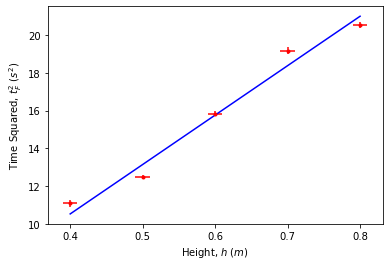

In [6]:
# Plot the curve

# Convert data and error into a form recognised by ODR
free_fall = RealData(h, t_f**2, sx=h_err, sy=2*t_f_err)

# Set up ODR
odr_f = ODR(free_fall, model, beta0=[25, 0.5]) # initial guess is y=25x+0.5

# run the regression
out_f = odr_f.run()
out_f.pprint()

print("Line of best fit:"+"y = ({:.1f} +/- {:.1f}) * x + ({:.1f} +/- {:.1f})".format(
  out_f.beta[0], out_f.sd_beta[0],
  out_f.beta[1], out_f.sd_beta[1]))

plt.figure()
plt.errorbar(h, t_f**2, xerr=h_err, yerr=2*t_f_err, fmt='.', color='red')
plt.plot(h, linear(out_f.beta, h), color='blue')

plt.xlabel("Height, $h$ ($m$)")
plt.ylabel("Time Squared, $t_F^2$ ($s^2$)")

plt.show()

In [7]:
# Calculating the moment of inertia
I_f = (out_f.beta[0]*m*g*r**2-2*m*r**2)/2
delta_I_f = I_f*((out_f.sd_beta[0]/out_f.beta[0])**2
                 +(2*delta_r/r)**2+(delta_m/m)**2)**0.5

print("I = {:.2f} +/- {:.2f}".format(
  I_f*1000, delta_I_f*1000)+" x10^-3 kgm^2")

I = 8.77 +/- 1.18 x10^-3 kgm^2


within uncertainty

### Precession Frequency

In [8]:
# Experimental data
mass = np.array([0.06, 0.06, 0.06, 0.07, 0.07, 0.07, 0.08, 0.08, 0.08, 0.09, 0.09, 0.09])
delta_mass = delta_m
tau = mass*g*l
delta_tau = tau*((delta_mass/mass)**2+(delta_g/g)**2+(delta_m/m)**2)**0.5
w_s1 = 40*np.pi/np.array([2.77, 2.75, 3.81, 3.1, 2.97, 2.69, 2.83, 2.77, 2.89, 2.56, 4.06, 2.89])
w_s2 = 40*np.pi/np.array([5.06, 4.15, 6.18, 5.17, 4.75, 6.47, 4.32, 4.19, 4.38, 4.52, 6.67, 4.6])
w_s = (w_s1+w_s2)/2 # mean of 2 w_s
delta_w_s = abs(w_s1-w_s2) # error before and after precession
t_p = np.array([13.65, 15.23, 11.08, 10.93, 11.33, 11.45, 10.91, 9.96, 10.88, 9.93, 7.23, 9.45])
w_p = 2*np.pi/t_p
delta_w_p = 2*np.pi*(1/(t_p-0.5)-1/(t_p+0.5)) # the error in time is 0.5 second
delta_y=tau/w_s*((delta_tau/tau)**2+(delta_w_s/w_s)**2)**0.5

Beta: [ 0.01041028 -0.00015257]
Beta Std Error: [0.00096484 0.00054193]
Beta Covariance: [[ 7.74804021e-05 -4.28780466e-05]
 [-4.28780466e-05  2.44435535e-05]]
Residual Variance: 0.012014751460906485
Inverse Condition #: 0.00038345056349657007
Reason(s) for Halting:
  Sum of squares convergence
Line of best fit:y = (0.010410 +/- 0.000965) * x + (-0.000153 +/- 0.000542)


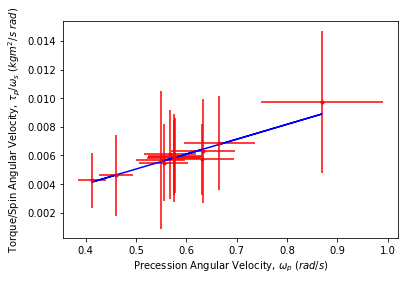

I = 10.41 +/- 0.96 x10^-3 kgm^2


In [9]:
# Plot the curve

# Convert data and error into a form recognised by ODR
precession = RealData(w_p, tau/w_s, sx=delta_w_p, sy=delta_y)

# Set up ODR
odr_p = ODR(precession, model, beta0=[0.0008, 0.2])

# run the regression
out_p = odr_p.run()
out_p.pprint()

print("Line of best fit:"+"y = ({:.6f} +/- {:.6f}) * x + ({:.6f} +/- {:.6f})".format(
  out_p.beta[0], out_p.sd_beta[0],
  out_p.beta[1], out_p.sd_beta[1]))

plt.figure()
plt.errorbar(w_p, tau/w_s, xerr=delta_w_p, yerr=delta_y, fmt='.', color='red')
plt.plot(w_p, linear(out_p.beta, w_p), color='blue')

plt.xlabel("Precession Angular Velocity, $\omega_p$ ($rad/s$)")
plt.ylabel("Torque/Spin Angular Velocity, $τ_p/\omega_s$ ($kgm^2/s$ $rad$)")

plt.show()

print("I = {:.2f} +/- {:.2f}".format(
  out_p.beta[0]*1000, out_p.sd_beta[0]*1000)+" x10^-3 kgm^2")

not within uncertainty
### Another Method of Precession

In [10]:
# Experimental data
mass2 = np.array([0.06, 0.07, 0.08, 0.09])
delta_mass2 = delta_m
tau2 = mass2*g*l
delta_tau2 = tau2*((delta_mass2/mass2)**2+(delta_g/g)**2+(delta_m/m)**2)**0.5
w_s2 = np.array([np.mean(w_s[:3]),np.mean(w_s[3:6]),np.mean(w_s[6:9]),np.mean(w_s[9:])])
delta_w_s2 = np.array([np.mean(delta_w_s[:3]),np.mean(delta_w_s[3:6]),np.mean(delta_w_s[6:9]),np.mean(delta_w_s[9:])])
w_p2 = np.array([np.mean(w_p[:3]),np.mean(w_p[3:6]),np.mean(w_p[6:9]),np.mean(w_p[9:])])
delta_w_p2 = np.array([np.mean(delta_w_p[:3]),np.mean(delta_w_p[3:6]),np.mean(delta_w_p[6:9]),np.mean(delta_w_p[9:])])
delta_x = w_s2*w_p2*((delta_w_s2/w_s2)**2+(delta_w_p2/w_p2)**2)**0.5

Beta: [0.0098808  0.00359674]
Beta Std Error: [0.00067299 0.01320049]
Beta Covariance: [[ 0.00027867 -0.00539974]
 [-0.00539974  0.10721451]]
Residual Variance: 0.0016252744328330154
Inverse Condition #: 0.011434703125549525
Reason(s) for Halting:
  Sum of squares convergence
Line of best fit:y = (0.009881 +/- 0.000673) * x + (0.003597 +/- 0.013200)


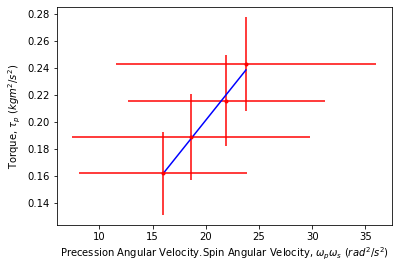

I = 9.88 +/- 0.67 x10^-3 kgm^2


In [11]:
# Plot the curve

# Convert data and error into a form recognised by ODR
precession2 = RealData(w_s2*w_p2, tau2, sx=delta_x, sy=delta_tau2)

# Set up ODR
odr_p2 = ODR(precession2, model, beta0=[0.0008, 0.2])

# run the regression
out_p2 = odr_p2.run()
out_p2.pprint()

print("Line of best fit:"+"y = ({:.6f} +/- {:.6f}) * x + ({:.6f} +/- {:.6f})".format(
  out_p2.beta[0], out_p2.sd_beta[0],
  out_p2.beta[1], out_p2.sd_beta[1]))

plt.figure()
plt.errorbar(w_s2*w_p2, tau2, xerr=delta_x, yerr=delta_tau2, fmt='.', color='red')
plt.plot(w_s2*w_p2, linear(out_p2.beta, w_s2*w_p2), color='blue')

plt.xlabel("Precession Angular Velocity.Spin Angular Velocity, $\omega_p\omega_s$ ($rad^2/s^2$)")
plt.ylabel("Torque, $τ_p$ ($kgm^2/s^2$)")

plt.show()

print("I = {:.2f} +/- {:.2f}".format(
  out_p2.beta[0]*1000, out_p2.sd_beta[0]*1000)+" x10^-3 kgm^2")

# Nutation

In [12]:
# Experimental Data
ws1 = 2*np.pi/np.array([8.33/53, 4.86/24, 5.86/36, 7.02/41, 6.44/37, 8/42, 9.57/57, 7.49/48])
ws2 = 40*np.pi/np.array([6.11, 5.84, 7.61, 6.23, 5.25, 6.37, 6.11, 4.54])
ws = (ws1+ws2)/2
delta_ws = abs(ws1-ws2)
tn = np.array([5.3, 5.69, 5.06, 5.33, 5.66, 5.93, 4.76, 4.16])/5
wn = 2*np.pi/tn
delta_wn = 2*np.pi*(1/(tn-0.1)-1/(tn+0.1)) # the error in time is 0.5 second

Beta: [ 0.32928437 -3.49575233]
Beta Std Error: [0.08663213 2.49525264]
Beta Covariance: [[  0.57119406 -16.403135  ]
 [-16.403135   473.86515038]]
Residual Variance: 0.0131393619640984
Inverse Condition #: 0.000106841509025454
Reason(s) for Halting:
  Sum of squares convergence
Line of best fit:y = (0.33 +/- 0.09) * x + (-3.50 +/- 2.50)


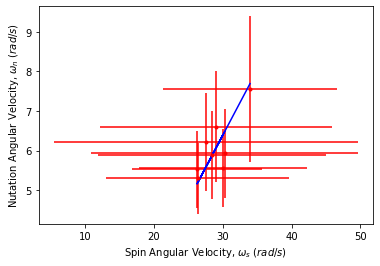

In [13]:
# Plot the curve

# Convert data and error into a form recognised by ODR
nutation = RealData(ws, wn, sx=delta_ws, sy=delta_wn)

# Set up ODR
odr_n = ODR(nutation, model, beta0=[2.5, 0.1])

# run the regression
out_n = odr_n.run()
out_n.pprint()

print("Line of best fit:"+"y = ({:.2f} +/- {:.2f}) * x + ({:.2f} +/- {:.2f})".format(
  out_n.beta[0], out_n.sd_beta[0],
  out_n.beta[1], out_n.sd_beta[1]))

plt.figure()
plt.errorbar(ws, wn, xerr=delta_ws, yerr=delta_wn, fmt='.', color='red')
plt.plot(ws, linear(out_n.beta, ws), color='blue')

plt.xlabel("Spin Angular Velocity, $\omega_s$ ($rad/s$)")
plt.ylabel("Nutation Angular Velocity, $\omega_n$ ($rad/s$)")

plt.show()

#### Improvements:
- more masses for the precesion part and then plot the torque against the ratio of spin and precession angular velocities
- measure the final spin time immediately after the precession or nutation
- drop different masses whilst keeping the velocity relatively constant for nutation to get relationship between nutation and strength of knock
- Experiment with having 2 disks